# P5 Starter - Time Series Analysis 

### Statistical Modeling to Deep Learning

##  Imports & Sanity Check (Do NOT Change)

In [25]:
import numpy as np 
import pandas as pd 
import os
from tqdm.notebook import tqdm
import statsmodels.api as sm # PACF, ACF
from typing import Tuple, List

# Viz:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/oil.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/stores.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/train.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/test.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv
/kaggle/input/helper1/helper.py


In [26]:
import importlib.util
import sys

file_path = '/kaggle/input/helper1/helper.py'  # full path to the file

spec = importlib.util.spec_from_file_location("helper", file_path)
helper = importlib.util.module_from_spec(spec)
sys.modules["helper"] = helper
spec.loader.exec_module(helper)

## Helper Utilities. Read the Function names at least so that you are not re-writing code

* **make_submission**: Helps you convert your predictions to competition submission ready files.
* **rmsle**: Implementation of the metric used to evaluate your score on the leaderboard.
* **lgbm_rmsle**: Definition that can be used to do train-val type training while printing metric scores.
* **data import**: Imports the necessary files into the notebook
* **preprocess_holidays**: Performs some necessary cleaning on the holiday dataset
* **preprocess_test_train**: Performs some necessary cleaning on the test and train dataset

## Load the data (Do NOT Change)

In [69]:
#########################
# DO NOT CHANGE
#########################
train, test, stores, transactions, oil, holidays = helper.data_import()
holidays, regional, national, local, events, work_day, _, _, _ = helper.preprocess_holidays(holidays)

## Section 1: EDA & Feature Engineering

### Q1 Left join transaction to train and then print the Spearman Correlation between Total Sales and Transactions.

In [70]:
merged_df = pd.concat([train,test])
merged_df = pd.merge(merged_df, transactions, on= ['date','store_nbr'], how = 'left')
merged_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0.0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0.0,NaN
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,NaN,0.0,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,NaN,1.0,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,NaN,148.0,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,NaN,8.0,2155.0


In [29]:
# TODO - q1
total_sales = merged_df.groupby(['date','store_nbr'])['sales'].sum().reset_index(name='total_sales')
transactions_average = merged_df.groupby(['date','store_nbr'])['transactions'].mean().reset_index(name='transactions_average')
merged_grouped = pd.merge(total_sales, transactions_average, on=['date','store_nbr'], how='inner')
spearman = merged_grouped['total_sales'].corr(merged_grouped['transactions_average'], method = 'spearman')
print(f"Spearman Correlation between Total Sales and Transactions:{spearman}")

Spearman Correlation between Total Sales and Transactions:0.8026966103771124


### Q2 Plot an 'ordinary least squares' trendline between transactions and sales to verify the spearman correlation value in Q1. [0.1 Points]

In [30]:
# TODO - q2
fig = px.scatter(merged_grouped, x="transactions_average", y="total_sales", \
                trendline="ols", trendline_color_override= "red",\
                title = "Total Transactions vs. Total Sales")
fig.write_html("/kaggle/working/q2.html")
fig.show(renderer='iframe')

### Q3 Plot these line charts in the notebook:

A) Transactions vs Date (all stores color coded in the same plot) 

B) Average monthly transactions

 C) Average Transactions on the days of the wee)


In [31]:
# TODO - q3 - Plot A
fig = px.line(merged_grouped, x='date', y="transactions_average",
             color= 'store_nbr',
             title= "Total Transactions Over Time",
             labels= {'total_transactions': 'Transaction Average'})
fig.write_html("/kaggle/working/q3a.html")
fig.show(renderer='iframe')

In [32]:
# TODO - q3 - Plot B
import calendar
transactions_2 = transactions.copy()
transactions_2["month"] = transactions_2['date'].dt.month
transactions_2 = transactions_2.groupby('month')['transactions'].mean().reset_index(name="transaction_avg")
fig = px.line(
    transactions_2, 
    x='month', 
    y='transaction_avg', 
    title="Monthly Transaction Average",
)
fig.update_xaxes(
    title="Month",
    tickmode='array',
    tickvals=list(range(1,13)),
    ticktext=[calendar.month_abbr[m] for m in range(1,13)]
)
fig.update_yaxes(title="Average Transactions")
fig.write_html("/kaggle/working/q3b.html")
fig.show(renderer='iframe')

In [33]:
# TODO - q3 - Plot C
transactions_v3 = transactions.copy()

transactions_v3['year'] = transactions_v3['date'].dt.year
transactions_v3['dayofweek'] =transactions_v3['date'].dt.dayofweek +1

transactions_v3 = transactions_v3.groupby(['year','dayofweek'])['transactions'].mean().reset_index(name = "transaction_avg")

fig = px.line(transactions_v3, x='dayofweek', y="transaction_avg",color = 'year', \
             title= "Transaction Averages per Day of the Week")
fig.update_xaxes(
    title="Day of Week",
    tickmode='array',
    tickvals=list(range(1,8)),
    ticktext=list(calendar.day_name)
)
fig.update_yaxes(title="Average Transactions")
fig.write_html("/kaggle/working/q3c.html")
fig.show(renderer='iframe')

### Q4 Use pandas' in-build (linear) interpolation to impute the missing oil values then overlay the imputed feature over the original.

Your new feature column should be called: `dcoilwtico_interpolated`

In [34]:
# Interpolate. 
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
oil['dcoilwtico'] = np.where(oil['dcoilwtico'] == 0 , np.nan, oil['dcoilwtico'] )
oil['dcoilwtico_interpolated'] = oil['dcoilwtico'].interpolate(method= "linear")
# Plot

fig = px.line(
    oil,
    x="date",
    y=['dcoilwtico', 'dcoilwtico_interpolated'],
    title="WTI Crude Oil Price – Original vs. Imputed Gaps",
    color_discrete_map={
        'dcoilwtico': 'blue',
        'dcoilwtico_interpolated': 'red'
    },
    labels={"value": "WTI price (USD)", "variable": "Series"}
)

fig.update_traces(
    selector=dict(name='dcoilwtico'),
    line=dict(width=2),
    name='Original'
)

fig.update_traces(
    selector=dict(name='dcoilwtico_interpolated'),
    line=dict(width=2, dash = "dot"),
    name='Imputed'
)

fig.update_xaxes(tickangle=-45)
fig.write_html('/kaggle/working/q4.html')
fig.show(renderer='iframe')

### Q5 Again, left join oil on the dataframe above and report the spearman correlation between oil and sales and oil and transactions

In [35]:
oil_join = oil[['date','dcoilwtico_interpolated']]
merged_oil = pd.merge(oil_join,merged_grouped, on = ['date'], how= 'left')

In [36]:
# Find correlation with sales & transactions
corr_sales_oil = merged_oil['total_sales'].corr(
                     merged_oil['dcoilwtico_interpolated'], method='spearman')

corr_transactions_oil = merged_oil['transactions_average'].corr(
                     merged_oil['dcoilwtico_interpolated'], method='spearman')

print("Correlation Between Oil and Sales:", corr_sales_oil)
print("Correlation Between Oil and Transactions:",corr_transactions_oil)

Correlation Between Oil and Sales: -0.291826437971285
Correlation Between Oil and Transactions: 0.0401054583437437


### Q6 Report the top-3 highest negative correlations between oil and sales of a particular product family. Now think whether oil should be discarded as a feature?

In [37]:
original_df = (pd.concat([train, test]).merge(transactions, on=['date', 'store_nbr'], how='left'))
original_df = (original_df.groupby(['family', 'date'], as_index=False).agg(total_sales=('sales', 'sum')))
family_df = original_df.merge(oil[['date', 'dcoilwtico_interpolated']],on='date', how='left')
family_df = family_df.groupby('family')[['total_sales', 'dcoilwtico_interpolated']].corr(method='spearman')
corr = (family_df.loc[(slice(None), 'total_sales'),'dcoilwtico_interpolated'].reset_index(name= 'spearman'))
top3 = corr.nsmallest(3, 'spearman')
print(top3)

                 family      level_1  spearman
16  HOME AND KITCHEN II  total_sales -0.777580
23            MAGAZINES  total_sales -0.710336
15   HOME AND KITCHEN I  total_sales -0.631058


### Q7. Implement the One hot encode function 

You just have to finish the one-hot encoder function definition for this one.

In [71]:
def one_hot_encoder(df, nan_as_category=True) -> Tuple[pd.DataFrame, List[str]]:
    # One hot encoding (pandas can do it on 1 line!) 
    original_columns = list(df.columns)
    print(original_columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    print(categorical_columns)
    for col in categorical_columns:
        df[col] = df[col].astype(str).str.replace(" ", "_")
    df= pd.get_dummies(df, columns =categorical_columns, dummy_na = nan_as_category )
    # Store the new columns in a list
    new_columns = [col for col in df.columns if col not in original_columns]
    
    print(new_columns)
    # Replace " " with "_" in column names.
    # Return the new dataframe and all the columns (as a list)
    return df, new_columns

In [72]:
#########################
# DO NOT CHANGE. 
# NOTE: Run this after you have implemented the one_hot_encoder function above.
#########################

train, test = helper.preprocess_test_train(merged_df, one_hot_encoder, stores)
len(train)

['date', 'events']
['events']
['events_Black_Friday', 'events_Cyber_Monday', 'events_Dia_de_la_Madre', 'events_Futbol', 'events_Terremoto_Manabi', 'events_Terremoto_Manabi1', 'events_Terremoto_Manabi10', 'events_Terremoto_Manabi11', 'events_Terremoto_Manabi12', 'events_Terremoto_Manabi13', 'events_Terremoto_Manabi14', 'events_Terremoto_Manabi15', 'events_Terremoto_Manabi16', 'events_Terremoto_Manabi17', 'events_Terremoto_Manabi18', 'events_Terremoto_Manabi19', 'events_Terremoto_Manabi2', 'events_Terremoto_Manabi20', 'events_Terremoto_Manabi21', 'events_Terremoto_Manabi22', 'events_Terremoto_Manabi23', 'events_Terremoto_Manabi24', 'events_Terremoto_Manabi25', 'events_Terremoto_Manabi26', 'events_Terremoto_Manabi27', 'events_Terremoto_Manabi28', 'events_Terremoto_Manabi29', 'events_Terremoto_Manabi3', 'events_Terremoto_Manabi30', 'events_Terremoto_Manabi4', 'events_Terremoto_Manabi5', 'events_Terremoto_Manabi6', 'events_Terremoto_Manabi7', 'events_Terremoto_Manabi8', 'events_Terremoto_Ma

/tmp/ipykernel_2397/392573475.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2397/392573475.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2397/392573475.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['holiday_national_Batalla_de_Pichincha', 'holiday_national_Carnaval', 'holiday_national_Dia_de_Difuntos', 'holiday_national_Dia_de_la_Madre1', 'holiday_national_Dia_del_Trabajo', 'holiday_national_Independencia_de_Cuenca', 'holiday_national_Independencia_de_Guayaquil', 'holiday_national_Navidad', 'holiday_national_Navidad1', 'holiday_national_Navidad2', 'holiday_national_Navidad3', 'holiday_national_Navidad4', 'holiday_national_Primer_Grito_de_Independencia', 'holiday_national_Primer_dia_del_ano', 'holiday_national_Primer_dia_del_ano1', 'holiday_national_Viernes_Santo', 'holiday_national_nan', 'holiday_regional_Provincializacion_Santa_Elena', 'holiday_regional_Provincializacion_de_Cotopaxi', 'holiday_regional_Provincializacion_de_Imbabura', 'holiday_regional_Provincializacion_de_Santo_Domingo', 'holiday_regional_nan', 'holiday_local_Cantonizacion_de_Cayambe', 'holiday_local_Cantonizacion_de_El_Carmen', 'holiday_local_Cantonizacion_de_Guaranda', 'holiday_local_Cantonizacion_de_Latacung

2976204

## Section 2

### Q8. EMA

Forecast window should be >=15 days since the test set is 15 days. **For this question use 16 as the forecast window**

In [40]:
test

,id,date,store_nbr,onpromotion,transactions,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,...,state_Pastaza,state_Pichincha,state_SantaElena,state_SantoDomingodelosTsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E
2976204,2974158.0,2017-08-01,1.0,0.0,1795.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2976205,2974159.0,2017-08-01,1.0,0.0,1795.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2976206,2974160.0,2017-08-01,1.0,0.0,1795.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2976207,2974161.0,2017-08-01,1.0,26.0,1795.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2976208,2974162.0,2017-08-01,1.0,0.0,1795.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002929,3000883.0,2017-08-15,9.0,0.0,2155.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3002930,3000884.0,2017-08-15,9.0,1.0,2155.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3002931,3000885.0,2017-08-15,9.0,148.0,2155.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3002932,3000886.0,2017-08-15,9.0,8.0,2155.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [86]:
results_list = []
stores = train['store_nbr'].unique()
families = [idx for idx in train.columns if idx.startswith("family_")]
results = pd.DataFrame(columns=["family", "store_nbr", "sales", "ema"])
train = train.drop_duplicates()

In [87]:
# Train EMAs for each family per store (pandas has an inbuilt ema function!)
# id is going to be row index +1 
for store in tqdm(stores, total=len(stores), desc="Stores"):
    store_num = train[train["store_nbr"] == store]
    for family in families:
        family_sales = train[train[family] == 1]
        
        store_family = family_sales.groupby(['store_nbr',family])['sales'].mean()
        ema = store_family.ewm(span=16, adjust=False).mean()


        sales_results = pd.DataFrame({
            "family": family,
            "store_nbr": store,
            "sales": ema.index,
            "ema": ema.values
        })
        results_list.append(sales_results)

results = pd.concat(results_list, ignore_index=True)

Stores:   0%|          | 0/54 [00:00<?, ?it/s]

In [88]:
results


,family,store_nbr,sales,ema
0,family_AUTOMOTIVE,1.0,"(1.0, 1.0)",3.220544
1,family_AUTOMOTIVE,1.0,"(2.0, 1.0)",3.473680
2,family_AUTOMOTIVE,1.0,"(3.0, 1.0)",4.152625
3,family_AUTOMOTIVE,1.0,"(4.0, 1.0)",4.136376
4,family_AUTOMOTIVE,1.0,"(5.0, 1.0)",4.290298
...,...,...,...,...
96223,family_SEAFOOD,9.0,"(50.0, 1.0)",41.160313
96224,family_SEAFOOD,9.0,"(51.0, 1.0)",44.099861
96225,family_SEAFOOD,9.0,"(52.0, 1.0)",38.978340
96226,family_SEAFOOD,9.0,"(53.0, 1.0)",34.849841


In [89]:
# Make the predictions

test_preds = []
families = [idx for idx in test.columns if idx.startswith("family_")]
for idx, row in tqdm(test.iterrows(), total=len(test)):
    store = row['store_nbr']
    family = None
    for f in families:
        if row[f] == 1:
            family = f
            break

    filtered = results[(results['store_nbr'] == store) & (results['family'] == family)]

    prediction = filtered['ema'].iloc[-1]
    test_preds.append(prediction)
        
# Use the make_submission utility function provided to save a submission CSV. 

# Submit to competition and note your RMSLE score somewhere for this model type.

# NOTE - 1: You still need to go on the right panel and click submit 
# (make_submission will NOT submit to competition -> It just makes a submission ready file)
# NOTE - 2: Ensure that you are not overwriting your submission.csv file in subsequent cells.

# Use the make_submission utility function provided to save a submission CSV.

helper.make_submission(test_preds, file_name="EMA_results.csv")

  0%|          | 0/26730 [00:00<?, ?it/s]

### Q9. PACF and ACF

Use lib sm 

(statsmodel.api is already imported as sm)

In [44]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

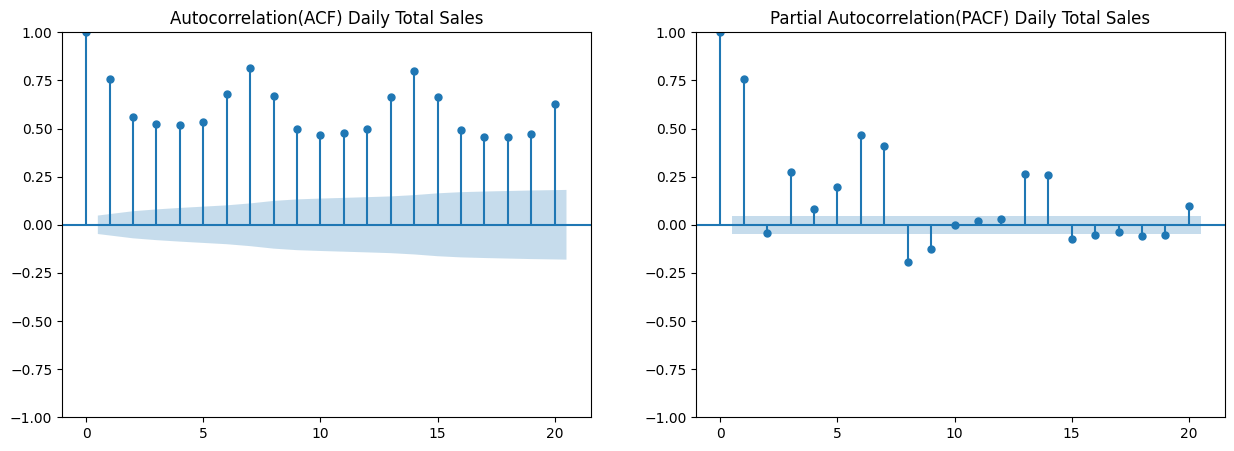

In [45]:
# 1. Group by date
total_sales = train.groupby('date')['sales'].sum().reset_index(name='total_sales')

# 2) Plot ACF & PACF up to lag 20
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot ACF and PACF, usually 20 lags are enough to see the pattern, most common configuration
# at lag 0, the correlation is 1, so we start from lag 1
# the relationship bewtween T and T-1 at each lagi
# whats meant by a lag is the time difference between two points in time
plot_acf(total_sales['total_sales'], lags=20,ax=ax[0],title="Autocorrelation(ACF) Daily Total Sales")
plot_pacf(total_sales['total_sales'],lags=20, ax=ax[1],title="Partial Autocorrelation(PACF) Daily Total Sales")

plt.show()


### Q10. ADF Test -> ARIMA

#### Differencing technique
This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [46]:
# 1. Compute and store the diff series
total_sales_diff = total_sales.copy()
total_sales_diff['diff'] = total_sales_diff['total_sales'].diff()
# 2. Drop NA or any other erroneous values.
total_sales_diff = total_sales_diff.dropna()
total_sales_diff

,date,total_sales,diff
1,2013-01-02,4.960924e+05,493580.78125
2,2013-01-03,3.614612e+05,-134631.18750
3,2013-01-04,3.544597e+05,-7001.53125
4,2013-01-05,4.773501e+05,122890.43750
5,2013-01-06,5.196954e+05,42345.28125
...,...,...,...
1664,2017-07-27,6.598498e+05,-80803.25000
1665,2017-07-28,8.350997e+05,175249.87500
1666,2017-07-29,1.032311e+06,197211.18750
1667,2017-07-30,1.123752e+06,91441.62500


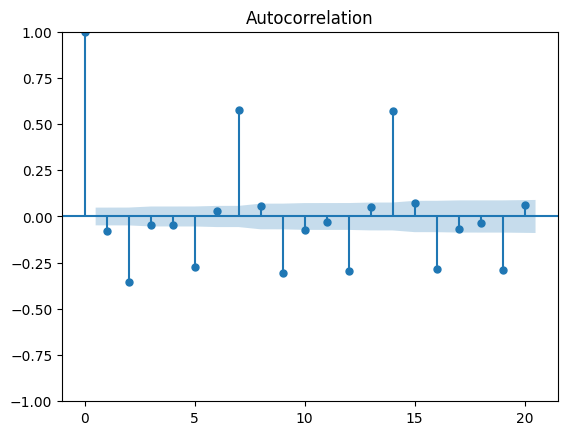

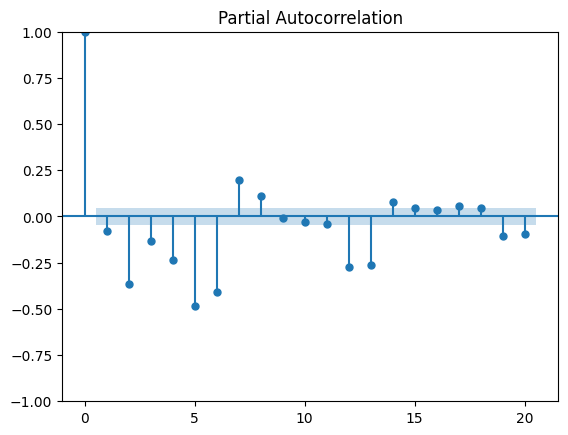

In [47]:

# Plot the ACF

##########
# TODO: Your plot code goes here:
plot_acf(total_sales_diff['diff'],lags=20)
plot_pacf(total_sales_diff['diff'],lags=20)
##########

##########

plt.show()

### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [48]:
from statsmodels.tsa.stattools import adfuller

In [49]:
# 1. Perform the ADF test
result = adfuller(total_sales_diff['diff'])

adf_statistic = result[0]
p_val = result[1]
# 2. Extract the test statistics and p-value

# 3. Print these values
print("ADF Statistic:",adf_statistic)
print("p-value:", p_val)

ADF Statistic: -11.553711234361751
p-value: 3.3987504192949185e-21


The ADF statistic is (around) -11.4. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-values (around)  i6.76e-2121, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

**TODO** Choose the right p, q and d values for your ARIMA model

In [50]:
# TODO: Replace with appropriate p,d,q values for ARIMA
p_arima = 2

d_arima = 1

q_arima = 1

In [51]:
# 1. Get sales series as training data (np array with appropriate dtype)

# total_sales['total_sales']
model = sm.tsa.ARIMA(total_sales['total_sales'].values.astype('float64'), order=(p_arima, d_arima, q_arima))
# 2. Using statsmodel.tsa lib. Initialize an ARIMA model with the p,d,q params you defined. 

# 3. Fit the model
result = model.fit()

In [52]:
# Print the post model fitting summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1669
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -22082.266
Date:                Thu, 24 Apr 2025   AIC                          44172.533
Time:                        22:42:43   BIC                          44194.210
Sample:                             0   HQIC                         44180.566
                               - 1669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5137      0.016     31.341      0.000       0.482       0.546
ar.L2         -0.3246      0.024    -13.491      0.000      -0.372      -0.277
ma.L1         -0.9102      0.012    -76.686      0.0

In [53]:
# Make predictions & submit to competition using your best model
predictions = result.forecast(steps=15)
pred_df = pd.DataFrame({'Date': list(test['date'].unique()), "Forecast": predictions})
pred_df.to_csv("/kaggle/working/ARIMA_results.csv")

## Section 3

### Q11 Define a validation set. What will be the most appropriate time period for this validation set?

In [58]:
train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,id,date,store_nbr,sales,onpromotion,transactions,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,...,state_Pastaza,state_Pichincha,state_SantaElena,state_SantoDomingodelosTsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E
0,0.0,2013-01-01,1.0,0.000000,0.0,NaN,13.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,2013-01-01,1.0,0.000000,0.0,NaN,13.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,2013-01-01,1.0,0.000000,0.0,NaN,13.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,2013-01-01,1.0,0.000000,0.0,NaN,13.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,2013-01-01,1.0,0.000000,0.0,NaN,13.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949469,2947423.0,2017-07-16,9.0,571.333008,0.0,1944.0,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2949470,2947424.0,2017-07-16,9.0,125.959999,0.0,1944.0,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2949471,2947425.0,2017-07-16,9.0,2041.967041,13.0,1944.0,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2949472,2947426.0,2017-07-16,9.0,0.000000,0.0,1944.0,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [73]:
# Get the val set:

first_date = test['date'].min()
last_date  = test['date'].max()

print(f"Testing period: {first_date} to {last_date}")

# Assumption: the validation set should be the same length as the test set 
# and immediately precede it
validation_duration = (last_date - first_date).days +1
val_start_date = first_date - pd.Timedelta(days=validation_duration)
val_end_date = first_date - pd.Timedelta(seconds=1)

# Filter the train set to define the validation set
val = train[(train['date'] >= val_start_date) & (train['date'] <= val_end_date)]

print(f"Validation period: {val_start_date} to {val_end_date}")
print(f"Number of records in validation set: {len(val)}")

# Remove validation set from training set to prevent data leakage
train = train[~train.index.isin(val.index)]


Testing period: 2017-08-01 00:00:00 to 2017-08-15 00:00:00
Validation period: 2017-07-17 00:00:00 to 2017-07-31 23:59:59
Number of records in validation set: 26730


### Q12. LightGBM

In [61]:
import lightgbm as lgb

In [74]:

# 1) Define features and labels (only once!)
features = [c for c in train.columns if c not in ['id','date','sales']]
Y_train = train['sales']
X_train = train[features]
Y_val =   val['sales']
X_val =   val[features]
X_test =  test[features]

for df in (X_train, X_val, X_test):
    for var in ['family','city','state','type']:
        dummy = [c for c in df.columns if c.startswith(f"{var}_")]
        df[var] = (df[dummy].idxmax(axis=1).str.split("_", n=1).str[1].astype("category"))
    df['store_nbr'] = df['store_nbr'].astype(int)
    df['store_nbr'] = df['store_nbr'].astype("category")
print(Y_train.shape, X_train.shape, Y_val.shape, X_val.shape, X_test.shape)
print( X_train.dtypes[['store_nbr','family','city','state','type']])


/tmp/ipykernel_2397/815096794.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2397/815096794.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2397/815096794.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2397

(2949474,) (2949474, 175) (26730,) (26730, 175) (26730, 175)
store_nbr    category
family       category
city         category
state        category
type         category
dtype: object


In [76]:
X_train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,store_nbr,onpromotion,transactions,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,events_Terremoto_Manabi1,...,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,family,city,state,type
0,1,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,AUTOMOTIVE,Quito,Pichincha,D
1,1,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,BABYCARE,Quito,Pichincha,D
2,1,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,BEAUTY,Quito,Pichincha,D
3,1,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,BEVERAGES,Quito,Pichincha,D
4,1,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,BOOKS,Quito,Pichincha,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949469,9,0.0,1944.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,POULTRY,Quito,Pichincha,B
2949470,9,0.0,1944.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,PREPAREDFOODS,Quito,Pichincha,B
2949471,9,13.0,1944.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,PRODUCE,Quito,Pichincha,B
2949472,9,0.0,1944.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,SCHOOLANDOFFICESUPPLIES,Quito,Pichincha,B


In [98]:
# Use the lgb.Dataset method to intialize your dataset iterables.
cats = ['store_nbr','family','city','state','type']
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, categorical_feature=cats)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, categorical_feature=cats)


In [99]:
# Fill the dict with appropriate params:
lgb_params = {
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'max_depth': 6,
    'verbose': 1,
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'nthread': -1,
}

In [100]:
# Define RMSLE Metric
def rmsle(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

def lgbm_rmsle(preds, train_data):
    labels = train_data.get_label()
    rmsle_val = rmsle(preds, labels)
    return 'RMSLE', rmsle_val, False

In [101]:
# Complete the model initialization/train params)
# Train LightGBM Model
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    feval=lgbm_rmsle
)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.747760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 2949474, number of used features: 175
[LightGBM] [Info] Start training from score 355.864093
Training until validation scores don't improve for 100 rounds


/tmp/ipykernel_2397/3317845821.py:3: RuntimeWarning:

invalid value encountered in log1p



Early stopping, best iteration is:
[91]	training's l2: 144330	training's RMSLE: nan	valid_1's l2: 85038.3	valid_1's RMSLE: 1.16734


In [120]:
# 1. Predict the sales value on your val set using the best_iteration recorded by the LGBM
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
val_rmsle = rmsle(y_pred_val, Y_val)
print(f"Validation Sales Value: {y_pred_val}")
# 2. Compute and print the RMSLE on this val set.
val_rmsle = rmsle(y_pred_val, Y_val)
print(f"Validation RMSLE: {val_rmsle}")

Validation Sales Value: [  14.78458447   14.78458447   14.78458447 ... 1665.95797876  132.41647182
   17.43028565]
Validation RMSLE: 1.1673356356015483


In [103]:
# 1. Pre-process your test set to appropriate format.
test_preds = model.predict(X_test)
submission_df = pd.DataFrame({'id': test['id'].astype(int),'sales': test_preds})
submission_df.to_csv("/kaggle/working/LightGBM_results.csv", index=False)
# 2. Predict -> Save using make_submission -> Submit to competition
# 3. Note your RMSLE for LGBM
# 1.17693

### Q13. CatBoost

In [115]:
from catboost import Pool, CatBoostRegressor

In [124]:
# Fill out missing params for catboost appropriately here:
catboost_params = {
    'iterations': 1000,           # Number of boosting rounds
    'learning_rate': 0.05,        # Learning rate for gradient boosting
    'depth': 6,                   # Depth of each tree
    'loss_function': 'RMSE',      # Loss function (Root Mean Squared Error for regression)
    'eval_metric': 'RMSE',        # Evaluation metric
    'random_seed': 42,            # Ensures reproducibility
    'early_stopping_rounds': 50,  # Stops training if no improvement after 50 rounds
    'verbose': 100                # Prints training progress every 100 rounds
}

In [125]:
# 1. Define the model
train_pool = Pool(data=X_train, label=Y_train, cat_features=cats)
val_pool   = Pool(data=X_val,   label=Y_val,   cat_features=cats)
model = CatBoostRegressor(**catboost_params)
# 2. Fit
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

0:	learn: 1059.0046251	test: 1236.1056537	best: 1236.1056537 (0)	total: 2.25s	remaining: 37m 31s
100:	learn: 425.4918077	test: 370.8276060	best: 370.8276060 (100)	total: 2m 42s	remaining: 24m 3s
200:	learn: 397.1800210	test: 323.3740233	best: 323.3740233 (200)	total: 5m 33s	remaining: 22m 6s
300:	learn: 381.3595333	test: 300.1577977	best: 300.1577977 (300)	total: 8m 23s	remaining: 19m 28s
400:	learn: 371.7985019	test: 288.4658676	best: 288.4559768 (398)	total: 11m 13s	remaining: 16m 46s
500:	learn: 364.6456899	test: 280.3904077	best: 280.3904077 (500)	total: 14m 2s	remaining: 13m 58s
600:	learn: 359.0678087	test: 273.5545062	best: 273.5545062 (600)	total: 16m 56s	remaining: 11m 14s
700:	learn: 354.5797969	test: 268.4959511	best: 268.4829179 (699)	total: 19m 46s	remaining: 8m 26s
800:	learn: 351.0140497	test: 264.6356081	best: 264.6356081 (800)	total: 22m 30s	remaining: 5m 35s
900:	learn: 348.0845139	test: 260.9116566	best: 260.9116566 (900)	total: 25m 16s	remaining: 2m 46s
999:	learn: 

In [126]:
# 3. Preprocess your test data appropriately

# 4. Make Predictions
test_preds_cat = model.predict(X_test)

In [127]:
# 5. Use make_submission -> Submit to competition
submission_df = pd.DataFrame({'id': test['id'].astype(int),'sales': test_preds_cat})
submission_df.to_csv("/kaggle/working/CatBoost_results.csv", index=False)
# 6. Note your RMSLE for this model
val_rmsle_cat = rmsle(test_preds_cat, Y_val)
print(f"Validation RMSLE: {val_rmsle_cat}")

Validation RMSLE: 1.1909909450720348


/tmp/ipykernel_31/3317845821.py:3: RuntimeWarning:

invalid value encountered in log1p



### Q14. XGBoost

In [90]:
from xgboost import XGBRegressor

In [91]:
# 1. Initialize model with random state = 42 to be consistent with CatBoost
model = XGBRegressor(
    random_state=42,
    enable_categorical=True,
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    max_depth=6,
    verbose=100
)
# 2. Fit
model.fit(
    X_train, Y_train,
    eval_set=[(X_val, Y_val)])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning:

[23:25:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.




[0]	validation_0-rmse:1230.62300
[1]	validation_0-rmse:1178.76871
[2]	validation_0-rmse:1132.16907
[3]	validation_0-rmse:1085.72817
[4]	validation_0-rmse:1040.12566
[5]	validation_0-rmse:1000.87138
[6]	validation_0-rmse:960.92964
[7]	validation_0-rmse:922.68643
[8]	validation_0-rmse:885.58712
[9]	validation_0-rmse:849.14329
[10]	validation_0-rmse:818.22076
[11]	validation_0-rmse:785.96167
[12]	validation_0-rmse:757.26280
[13]	validation_0-rmse:730.36124
[14]	validation_0-rmse:702.02443
[15]	validation_0-rmse:677.87672
[16]	validation_0-rmse:654.97253
[17]	validation_0-rmse:631.12925
[18]	validation_0-rmse:610.01809
[19]	validation_0-rmse:589.56209
[20]	validation_0-rmse:570.22225
[21]	validation_0-rmse:551.32251
[22]	validation_0-rmse:533.81093
[23]	validation_0-rmse:519.17818
[24]	validation_0-rmse:503.16389
[25]	validation_0-rmse:487.73307
[26]	validation_0-rmse:474.11249
[27]	validation_0-rmse:461.76641
[28]	validation_0-rmse:449.60889
[29]	validation_0-rmse:437.72210
[30]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [93]:
# 3. Make Predictions.
test_preds_xg = model.predict(X_test)

In [96]:
# 4. make_submission -> Submit to competition 
submission_df = pd.DataFrame({'id': test['id'].astype(int),'sales': test_preds_xg})
submission_df.to_csv("/kaggle/working/XGBoost_results.csv", index=False)
# 6. Note your RMSLE for this model
#    0.72161

Validation RMSLE: 0.878162145614624


/tmp/ipykernel_2397/3317845821.py:3: RuntimeWarning:

invalid value encountered in log1p



### Q15. Optuna for automatic hyperparameter optimization

In [97]:
def objective_lgb(trial):
    # 1. Define the parameter search space
    
    # 2. Create datasets (train, val) for LightGBM

    # 3. Train the model

    # 4. Evaluate on the validation set

    # 5. Return the metric score
    
    pass

# Create Optuna study to minimize the objective function

start = time.time()
# 1. Create the optuna study and specify appropriate direction

# 2. Optimize (pay attention to recommended trials; 50 takes too long)

# 3. Get the best parameters

# 4. Print them.
# print("Best parameters:", best_params)

print("Took:", time.time() - start, "seconds")

NameError: name 'time' is not defined

In [ ]:
# Make a competition submission using these parameters
# Note these values.

In [ ]:
# Do the same for Catboost

In [ ]:
# Do the same for XGBoost

### Q16. Which out of the three Catboost vs LightGBM vs XGBoost provides the best score? Why do you think this model is more suited to this dataset/problem?

In [ ]:
print("<Your answer goes here>")

## Optional Extra Credit Section - Achieve the lowest score

### Cross Validation Strategies & Ensembling

In [ ]:
# 1. Try different Validation sets 
# 2. Try ensembling different methods used in this assignment together